In [5]:
import numpy as np
import pandas as pd
import nltk
import re
import joblib
import gensim.corpora as corpora
from gensim.corpora import MmCorpus
from nltk.tokenize import TweetTokenizer
from wordfreq import top_n_list
from collections import Counter

import os

from time import time

from numpy import *
import math
import matplotlib.pyplot as plt


from gensim.models.coherencemodel import CoherenceModel

from nltk import FreqDist
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import string

import gensim
import spacy
import en_core_web_sm

import pyLDAvis.gensim


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alejandro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Model number

In [6]:
y = 6

# Dataset

In [7]:
df = pd.read_csv("../../../Data_Extract&Analysis/uber_support_csv_with_duplicates/uber_support.csv")
df.shape

(223474, 35)

## Drop duplicates

In [8]:
df.drop_duplicates(inplace=True, subset="tweet")

In [9]:
df

,cashtags,created_at,date,day,geo,hashtags,hour,id,language,link,...,trans_src,translate,tweet,urls,user_id,user_id_str,user_rt,user_rt_id,username,video
0,[],1.585699e+12,2020-03-31 23:58:31,2.0,NaN,[],23.0,1.245138e+18,en,https://twitter.com/ExposedUber/status/1245138...,...,NaN,NaN,@LauraKellyKS @KansasGOP why did @Uber_Support...,[],1.142463e+18,1.142463e+18,NaN,NaN,ExposedUber,0.0
1,[],1.585699e+12,2020-03-31 23:52:51,2.0,NaN,[],23.0,1.245137e+18,en,https://twitter.com/ExposedUber/status/1245137...,...,NaN,NaN,@Uber_Support why did @Uber_Support and uber ...,[],1.142463e+18,1.142463e+18,NaN,NaN,ExposedUber,0.0
2,[],1.585699e+12,2020-03-31 23:51:11,2.0,NaN,[],23.0,1.245137e+18,en,https://twitter.com/ExposedUber/status/1245136...,...,NaN,NaN,why did @Uber_Support @Uber not follow thru wi...,[],1.142463e+18,1.142463e+18,NaN,NaN,ExposedUber,0.0
3,[],1.585699e+12,2020-03-31 23:50:58,2.0,NaN,[],23.0,1.245137e+18,en,https://twitter.com/cjm118/status/124513653487...,...,NaN,NaN,Same song and dance @Uber @Uber_Support @dkhos...,[],2.588586e+07,2.588586e+07,NaN,NaN,cjm118,1.0
4,[],1.585698e+12,2020-03-31 23:46:27,2.0,NaN,[],23.0,1.245135e+18,en,https://twitter.com/Behemoth0089/status/124513...,...,NaN,NaN,"@Uber_Support Hey, I'm receiving ride reports ...",[],9.841742e+07,9.841742e+07,NaN,NaN,Behemoth0089,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223469,[],1.596240e+12,2020-08-01 00:06:47,6.0,NaN,[],0.0,1.289352e+18,en,https://twitter.com/decemberangel86/status/128...,...,NaN,NaN,@Uber_Support need help asap on current order,[],1.258379e+09,1.258379e+09,NaN,NaN,decemberangel86,0.0
223470,[],1.596240e+12,2020-08-01 00:06:36,6.0,NaN,[],0.0,1.289352e+18,en,https://twitter.com/haleyluu_/status/128935179...,...,NaN,NaN,@Uber_Support Nothing got resolved 🤷‍♀️,[],3.838520e+08,3.838520e+08,NaN,NaN,haleyluu_,0.0
223471,[],1.596240e+12,2020-08-01 00:04:39,6.0,NaN,[],0.0,1.289351e+18,en,https://twitter.com/ninjitalia/status/12893513...,...,NaN,NaN,@Uber_Support @Tesla 2 trips in a row now as I...,[],1.800323e+08,1.800323e+08,NaN,NaN,ninjitalia,0.0
223472,[],1.596240e+12,2020-08-01 00:00:41,6.0,NaN,[],0.0,1.289350e+18,en,https://twitter.com/raveneverdies/status/12893...,...,NaN,NaN,"after @Uber_Support card changed, they did not...",[],5.038246e+08,5.038246e+08,NaN,NaN,raveneverdies,0.0


# Functions

## Emoticons variable

In [10]:
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

## Preprocess

In [11]:
def preprocess(words):
    
    tokens = []
   
    # Clean urls, punct, strange characters, emojis, emoticons
    char= re.compile(r'^[a-zA-Z]$')
    punct=re.compile(r'[.,-,:,<,;,(,=]')
    ht = re.compile(r'http.')
    bar = re.compile(r'//*')
    pr = ["rt","@","http","https","'s",'...', 'english', 'translation','):',
          '. .', '..','2-5','<3',']:','“','”','’','. ...','___','__','=(','‘','—','°','¢','•','®','—','…',
          '... .','--->','–','»','«','£','-->','×','->','©','\n','™','¤']
    no_emoji = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE) 
    
    no_emoticon = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    no_html_pattern = re.compile('<.*?>')
    
    stoplist = stopwords.words('english')
    punctuation = set(string.punctuation)
    
   
    # TOKENIZER
    tknzr = TweetTokenizer()
    tokens = tknzr.tokenize(words)
    tokens = [w.lower() for w in tokens] 
    
    #Remove numbers
    pattern = '[0-9]'
    tokens = [re.sub(pattern, '', i) for i in tokens] 
    
    # Punctuation
    tokens = [w for w in tokens if  w not in punctuation]
        
    # Clean emojis,urls,bars
    tokens = [w.replace('#', '') for w in tokens if not w.startswith('@') if w not in pr 
            if not bar.search(w) if not ht.search(w) if not char.search(w) if not punct.search(w)
            if not w.isdigit() if not no_emoji.search(w) if not no_emoticon.search(w) if not no_html_pattern.search(w)]
    
    # Remove non alphanumeric
    tokens = [w for w in tokens if w.isalpha()]

    
    # Remove english stopwords
    tokens = [w for w in tokens if w not in stoplist]
    
    #Remove tokens with length < 1
    tokens = [word for word in tokens if len(word)>1] 
    
    return tokens

## Lemmatization

In [12]:
nlp = en_core_web_sm.load()

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

## Preprocess of tweets

### Simple preprocess

In [13]:
texts = [preprocess(document) for document in df['tweet']]

In [14]:
texts

[['follow',
  'thru',
  'promise',
  'disinfecting',
  'materials',
  'drivers',
  'cars',
  'supplies',
  'keep',
  'drivers',
  'safe',
  'tele',
  'agents',
  'hang',
  'drivers',
  'call',
  'ask',
  'sbout',
  'supplies'],
 ['uber',
  'follow',
  'thru',
  'promise',
  'disinfecting',
  'materials',
  'drivers',
  'cars',
  'supplies',
  'keep',
  'drivers',
  'safe',
  'tele',
  'agents',
  'hang',
  'drivers',
  'call',
  'ask',
  'sbout',
  'supplies',
  'explain',
  'please'],
 ['follow',
  'thru',
  'promise',
  'disinfecting',
  'materials',
  'drivers',
  'cars',
  'supplies',
  'keep',
  'drivers',
  'safe',
  'tele',
  'agents',
  'hang',
  'drivers',
  'call',
  'ask',
  'sbout',
  'supplies',
  'explain',
  'please'],
 ['song',
  'dance',
  'dead',
  'wrong',
  'handling',
  'pandemic',
  'plight',
  'workers',
  'know'],
 ['hey', 'receiving', 'ride', 'reports', 'email', 'even', 'account', 'guys'],
 ['done'],
 ['uber', 'gives', 'ride', 'request', 'go', 'app', 'gone', 'r

### Lemmatize

In [15]:
texts = lemmatization(texts)


### Save texts

In [16]:
joblib.dump(texts, 'texts.pkl')

['texts.pkl']

In [17]:
texts = joblib.load('texts.pkl')

In [18]:
texts

[['follow',
  'promise',
  'disinfect',
  'material',
  'driver',
  'car',
  'supply',
  'keep',
  'driver',
  'safe',
  'tele',
  'agent',
  'hang',
  'driver',
  'call',
  'ask',
  'sbout',
  'supply'],
 ['uber',
  'follow',
  'thru',
  'promise',
  'disinfect',
  'material',
  'driver',
  'car',
  'supply',
  'keep',
  'driver',
  'safe',
  'tele',
  'agent',
  'hang',
  'driver',
  'call',
  'ask',
  'sbout',
  'supply',
  'explain'],
 ['follow',
  'promise',
  'disinfect',
  'material',
  'driver',
  'car',
  'supply',
  'keep',
  'driver',
  'safe',
  'tele',
  'agent',
  'hang',
  'driver',
  'call',
  'ask',
  'sbout',
  'supply',
  'explain'],
 ['song',
  'dance',
  'dead',
  'wrong',
  'handle',
  'pandemic',
  'plight',
  'worker',
  'know'],
 ['receive', 'ride', 'report', 'email', 'even', 'account', 'guy'],
 ['do'],
 ['uber', 'give', 'ride', 'request', 'go', 'app', 'go', 'right', 'away'],
 ['way',
  'worried',
  'privacy',
  'dm',
  'say',
  'continue',
  'work',
  'support

### Filter unfrequent words

In [19]:
#deleted_words = ['ahora', 'antes', 'después', 'tarde', 'luego', 'ayer', 'temprano', 'ya', 'todavía', 'anteayer', 'aún', 'pronto', 'hoy',
#           'aquí', 'ahí', 'allí', 'cerca', 'lejos', 'fuera', 'dentro', 'alrededor', 'aparte', 'encima', 'debajo', 'delante',
#           'detrás', 'así', 'bien', 'mal', 'despacio', 'deprisa', 'como', 'mucho', 'poco', 'muy', 'casi', 'todo', 'nada',
#           'algo', 'medio', 'demasiado', 'bastante', 'más', 'menos', 'además', 'incluso', 'también', 'sí', 'también',
#           'asimismo', 'no', 'tampoco', 'jamás', 'nunca', 'deber', 'poder', 'querer', 'saber', 'soler', 'cabify']

#no_accents_words = []
#for word in deleted_words:
#    no_accents_words.append(normalize(word))
    
#deleted_words = list(set(deleted_words+no_accents_words))

#rare_words_dic = dict((word,v )for word,v in cnt.items() if v <= 5 )
#rare_words = list(rare_words_dic.keys()) + deleted_words
#print(len(rare_words))



#texts = [[token for token in tweet if token not in rare_words] for tweet in texts]


In [20]:
word_list = [word for tweet in texts for word in tweet]
words_dist = FreqDist(word_list)

deleted_words = [token[0] for token in list(filter(lambda x: x[1]<=5,words_dist.items()))]
deleted_words = set(deleted_words)
texts = [[token for token in text if token not in deleted_words] for text in texts]

### Stemming

In [21]:
stemmer = SnowballStemmer("english")
texts = [[stemmer.stem(token) for token in text] for text in texts]

### Bigrams

In [22]:
bigram = gensim.models.Phrases(texts, min_count=10) 
texts = [bigram[text] for text in texts]

### Cleaning the texts 

In [23]:
texts = [[word for word in tweet if len(word)>2] for tweet in texts]
joblib.dump(texts, 'fulltexts.pkl')
print(len(texts))
texts = [tweet for tweet in texts if (len(tweet)>0)]
print(len(texts))


215387
212400


## Dictionary and corpus

In [24]:
dictionary = corpora.Dictionary(texts)
print(dictionary)

Dictionary(7964 unique tokens: ['agent', 'ask', 'call', 'car', 'disinfect']...)


In [25]:
corpus = [dictionary.doc2bow(doc) for doc in texts]
print(len(corpus))

212400


In [26]:
words = []
for i in dictionary:
    words += [dictionary.get(i)] 

words.sort()

## Save results

In [27]:
path = "./results/variables"
try:
    if not os.path.isdir(path):
        os.makedirs(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Successfully created the directory ./results/variables 


In [28]:
with open("results/variables/dictionary_alphabetical.txt", "w") as out_file:
    for word in words:
        out_file.write(word)
        out_file.write("\n")
#words

UnicodeEncodeError: 'charmap' codec can't encode characters in position 0-3: character maps to <undefined>

In [29]:
words

['aadhar',
 'aap',
 'aaya',
 'abandon',
 'abd',
 'abduct',
 'abdul',
 'abeg',
 'abhi',
 'abhishek',
 'abhorr',
 'abi',
 'abid',
 'abil',
 'abl',
 'ableism',
 'ableist',
 'abn',
 'abroad',
 'abrupt',
 'absent',
 'absolut',
 'absolut_absurd',
 'absolut_appal',
 'absolut_disgrac',
 'absolut_disgust',
 'absolut_joke',
 'absolut_ridicul',
 'absolut_rubbish',
 'absolut_shock',
 'absolut_useless',
 'abstract',
 'absurd',
 'abt',
 'abu_dhabi',
 'abuja',
 'abus',
 'abus_languag',
 'abysm',
 'abyss',
 'acc',
 'acceler',
 'accent',
 'accept',
 'accept_receit',
 'access',
 'accessori',
 'accid',
 'accident',
 'accnt',
 'accommod',
 'accompani',
 'accomplish',
 'accont',
 'accord',
 'accord_standard',
 'account',
 'account_holder',
 'accout',
 'accra',
 'accredit',
 'accru',
 'acct',
 'accumul',
 'accur',
 'accuraci',
 'accus',
 'accus_fraud',
 'accus_lie',
 'accus_wear',
 'accusatori',
 'ach',
 'achiev',
 'ack',
 'acknowledg',
 'aclu',
 'acnt',
 'acount',
 'acquir',
 'act',
 'act_togeth',
 'action

In [30]:
joblib.dump(texts, "results/variables/texts.pkl")
dictionary.save('results/variables/dictionary.dict')
MmCorpus.serialize("results/variables/corpus.corp", corpus)


In [ ]:
dic_ordered = sorted(words , key = len)
with open("results/variables/dictionary_ordered.txt", "w") as out_file:
    for word in dic_ordered:
        out_file.write(word)
        out_file.write("\n")

# LDA Models

## Load variables

In [31]:
texts = joblib.load("results/variables/texts.pkl")
dictionary = corpora.Dictionary.load("results/variables/dictionary.dict")
corpus = MmCorpus("results/variables/corpus.corp")


## Compute LDA coherence and perplexity

In [32]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, iterations, random, passes):

    coherence_values = []
    perplexity = []
    model_list = []
    for num_topics in range(start, limit):
        model = gensim.models.LdaMulticore(corpus=corpus,
                                          id2word=dictionary,
                                          num_topics=num_topics,
                                          chunksize=100,
                                          random_state=random,
                                          iterations = iterations,
                                          passes=passes,
                                          #alpha=a,
                                          #eta=b,
                                          workers=33,
                                          per_word_topics=True)        
       # model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state= random, iterations=iterations, passes = passes)
        model_list.append(model)
        
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
        perplexity_model_lda = model.log_perplexity(corpus)
        perplexity.append(perplexity_model_lda)
        
    return model_list, coherence_values, perplexity

In [33]:
start = time()
model_list, coherence_values, perplexity_model_lda  = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts, start=1, limit=40, iterations = 50, random = 100, passes = 10)
print('Time used for calculating LDA: {:.2f}s'.format(time()-start)) 

Time used for calculating LDA: 12547.44s


## Load best coherence model

### Word distriburtion

In [34]:
id = coherence_values.index(max(coherence_values))
best_model = model_list[id]
best_model.print_topics(num_words = 20)

[(0,
  '0.056*"uber" + 0.048*"account" + 0.047*"help" + 0.036*"use" + 0.033*"get" + 0.032*"tri" + 0.023*"number" + 0.023*"app" + 0.023*"email" + 0.017*"contact" + 0.017*"say" + 0.017*"work" + 0.016*"phone" + 0.014*"need" + 0.013*"eat" + 0.012*"card" + 0.011*"support" + 0.011*"phone_number" + 0.011*"call" + 0.009*"code"'),
 (1,
  '0.051*"driver" + 0.049*"uber" + 0.018*"car" + 0.018*"drive" + 0.013*"peopl" + 0.012*"know" + 0.011*"work" + 0.009*"good" + 0.008*"make" + 0.008*"get" + 0.007*"well" + 0.007*"rider" + 0.007*"vehicl" + 0.006*"need" + 0.006*"want" + 0.006*"take" + 0.006*"use" + 0.006*"right" + 0.006*"think" + 0.006*"report"'),
 (2,
  '0.047*"ride" + 0.041*"uber" + 0.038*"driver" + 0.036*"trip" + 0.034*"charg" + 0.033*"pay" + 0.026*"take" + 0.017*"show" + 0.016*"book" + 0.012*"cab" + 0.011*"cash" + 0.011*"amount" + 0.010*"today" + 0.010*"ask" + 0.009*"check" + 0.009*"money" + 0.008*"fare" + 0.008*"payment" + 0.008*"servic" + 0.008*"cancel"'),
 (3,
  '0.120*"order" + 0.040*"food" +

### Plot coherence results

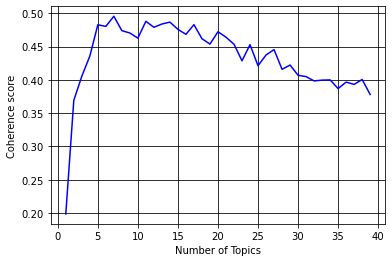

In [35]:
x = range(1,40)

plt.plot(x, coherence_values, 'b')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.grid(True,color='black')
plt.show()

### Save lda, coherence and perplexity results

In [36]:
path = './results/ldamodel'
try:
    if not os.path.isdir(path):
        os.makedirs(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Successfully created the directory ./results/ldamodel 


In [37]:

joblib.dump(model_list, "results/ldamodel/model_list_{}.pkl".format(y))
joblib.dump(coherence_values, "results/ldamodel/coherence_values_{}.pkl".format(y))
joblib.dump(perplexity_model_lda, "results/ldamodel/perplexity_model_lda_{}.pkl".format(y))

['results/ldamodel/perplexity_model_lda_6.pkl']

### PyLDAvis visual representation

In [7]:
pyLDAvis.enable_notebook()

model=pyLDAvis.gensim.prepare(best_model, corpus, dictionary=dictionary)
pyLDAvis.save_html(model,'results/ldamodel/best_model.html')

model2=pyLDAvis.gensim.prepare(model_list[10], corpus, dictionary=dictionary)
pyLDAvis.save_html(model2,'results/ldamodel/2best_model.html')

/home/alejandro/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## LDA Mallet for optimizing

### Load variables

In [ ]:
texts = joblib.load("results/variables/texts.pkl")
dictionary = corpora.Dictionary.load("results/variables/dictionary.dict")
corpus = MmCorpus("results/variables/corpus.corp")

### Train Model

In [ ]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path

In [ ]:
def compute_coherence_values_mallet(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    perplexity = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

In [ ]:
start = time()
model_list_mallet, coherence_values_mallet = compute_coherence_values_mallet(dictionary=dictionary, corpus=corpus, texts=texts, start=1, limit=40, step=1)
print('Time used for calculating LDA_MALLET: {:.2f}s'.format(time()-start)) 

### Plot results

In [ ]:
x = range(1,40)

plt.plot(x, coherence_values_mallet, 'b')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.grid(True,color='black')
plt.show()

### Save lda,coherence and perplexity results

In [ ]:
path = './results/mallet'
try:
    if not os.path.isdir(path):
        os.makedirs(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

In [ ]:
joblib.dump(model_list_mallet, "results/mallet/model_list_{}.pkl".format(y))
joblib.dump(coherence_values_mallet, "results/mallet/coherence_values_{}.pkl".format(y))
